<a href="https://colab.research.google.com/github/D4n1elR0drigues/TCC/blob/main/EXECU%C3%87%C3%83O_TREINADO_%5BMain_Code%5D_Trading_Robot_4_0_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader

from tqdm import tqdm_notebook, tqdm
from collections import deque

import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
import datetime

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from google.colab import files

import shutil

import time

import os

from pickle import TRUE

import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

# Monte o Google Drive no ambiente do Colab


<Figure size 2200x1500 with 0 Axes>

In [ ]:
# Defining our Deep Q-Learning Trader

class AI_Trader():

# -----------------------------------------------------------------------

  # CONSTRUTOR

  def __init__(self, state_size, action_space=3, model_name="AITrader", deterministic=True):

    self.state_size = state_size # Tamanho da entrada da rede neural
    self.action_space = action_space # Espaço de ação será 3, Comprar, Vender, Sem Ação (Tamanho da saída da rede neural)
    self.memory = deque(maxlen=2000) # Memória com 2000 posições. A função Deque permite adicionar elementos ao final, enquanto remove elementos do início.
    self.inventory = [] # Terá as comprar que já fizemos
    self.model_name = model_name # Nome do modelo para o Keras

    self.gamma = 0.95 # Parâmetro que ajudará a maximizar a recompensa
    self.epsilon = 1.0 # Taxa de aleatoriedade para atitudes ganacioas do algorítimo.
    self.epsilon_final = 0.01 # Taxa final reduzida
    self.epsilon_decay = 0.995 # Velocidade de decaimento da taxa

    self.deterministic = deterministic

    self.model = self.model_builder() # Inicializa um modelo e de rede neural e salva na classe

# -----------------------------------------------------------------------

  # DEFININDO A REDE NEURAL

  def model_builder(self):

    model = tf.keras.models.Sequential()
    model.add(layers.Dense(units=32, activation='relu', input_dim=self.state_size))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.Dense(units=self.action_space, activation='linear')) # De maneira geral, teremos 3 saída na rede geral (número de espaços de ação)


    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001)); # Compilamos o modelo

    return model # Retornamos o modelo pela função.

# -----------------------------------------------------------------------

  # FUNÇÃO DE TRADE
  # Usa o Epsilon e um número aleatório para definir se usará um dado aleatório ou a previsão da rede.

  def trade(self, state, use_random_action=True):
    if use_random_action and random.random() <= self.epsilon:
      return random.randrange(self.action_space)  # Aleatoriedade epsilon-greedy
    actions = self.model.predict(state)
    return np.argmax(actions[0])  # Sem aleatoriedade ou com aleatoriedade controlada pelo parâmetro



# -----------------------------------------------------------------------

  # LOTE DE TREINAMENTO

  # Definindo o modelo para treinamento do lote

  def batch_train(self, batch_size): # Função que tem o tamanho do lote como argumento

    batch = [] # Iremos usar a memória como lote, por isso iniciamos com uma lista vazia

    # Iteramos sobre a memória, adicionando seus elementos ao lote batch
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i])

    # Agora temos um lote de dados e devemos iterar sobre cada estado, recompensa,
    # proximo_estado e conclusão do lote e treinar o modelo com isso.
    for state, action, reward, next_state, done in batch:
      reward = reward

      # Se não estivermos no último agente da memória, então calculamos a
      # recompensa descontando a recompensa total da recompensa atual.
      if not done:
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

      # Fazemos uma previsão e alocamos à varivel target
      target = self.model.predict(state)
      target[0][action] = reward

      # Treinamos o modelo com o estado, usando a previsão como resultado esperado.
      self.model.fit(state, target, epochs=1, verbose=0)

    # Por fim decrementamos o epsilon a fim de gradativamente diminuir tentativas ganaciosas.
    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay

# -----------------------------------------------------------------------


In [ ]:
# Stock Market Data Preprocessing

# Definiremos algumas funções auxiliares

# Sigmoid
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# Função para formatar texto
def stock_price_format(n):
  if n < 0:
    return "- # {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

# Busca dados no Yahoo Finance
# Formato data = "yyyy-mm-dd"
def dataset_loader(stock_name, initial_date, final_date):

  yfin.pdr_override()

  dataset = pdr.get_data_yahoo(stock_name, start=initial_date, end=final_date)

  start_date = str(dataset.index[0]).split()[0]
  end_date = str(dataset.index[1]).split()[0]

  close = dataset['Close']

  return close

In [ ]:
# State Creator


def state_creator(data, timestep, window_size):

  # O index incial (starting_id) será o timestep (passos/dias que já foram dados)
  # menos o tamanho da janela, que serão os dias olhados para trás.
  starting_id = timestep - window_size + 1


  # Lógica para preencher os dados vindos da tabela Data, no array windowed_data

  if starting_id >= 0: # No geral este será a condição sempre executada
    windowed_data = data[starting_id: timestep + 1]

  else: # Condição executada apenas nos primeiros valores
    windowed_data =- starting_id * [data[0]] + list(data[0:timestep + 1])

  state = [] # Criação de uma array para retorno, com o estado.

  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i + 1] - windowed_data[i]))

  return np.array([state])

In [ ]:
# Training the Q-Learning Trading Agent

window_size = 10
episodes = 2

batch_size = 32
data_samples = len(data) - 1

trader = AI_Trader(window_size)
trader.model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                352       
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dense_15 (Dense)            (None, 3)                 387       
                                                                 
Total params: 11171 (43.64 KB)
Trainable params: 11171 (43.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Saving ai_trader_2 (2).h5 to ai_trader_2 (2) (5).h5
[*********************100%%**********************]  1 of 1 completed


  0%|          | 0/531 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step


  0%|          | 1/531 [00:00<00:56,  9.32it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/531 [00:00<00:36, 14.39it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/531 [00:00<00:33, 15.86it/s]

1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


  1%|▏         | 7/531 [00:00<00:30, 17.01it/s]

1/1 [==============================] - 0s 16ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 9/531 [00:00<00:30, 17.36it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 11/531 [00:00<00:29, 17.38it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 13/531 [00:00<00:29, 17.40it/s]

1/1 [==============================] - 0s 16ms/step
 - AI Trader Comprou:  $ 27.549999
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 15/531 [00:00<00:29, 17.70it/s]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 27.000000  - Lucro: - # 0.549999
1/1 [==============================] - 0s 16ms/step


  3%|▎         | 17/531 [00:01<00:29, 17.70it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 19/531 [00:01<00:29, 17.53it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 21/531 [00:01<00:29, 17.58it/s]

1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


  4%|▍         | 23/531 [00:01<00:28, 17.82it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


  5%|▍         | 25/531 [00:01<00:28, 17.88it/s]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 27/531 [00:01<00:28, 17.68it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 29/531 [00:01<00:29, 17.16it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 31/531 [00:01<00:28, 17.27it/s]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 33/531 [00:01<00:28, 17.50it/s]

 - AI Trader Comprou:  $ 21.670000
1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 24.059999  - Lucro: $ 2.389999
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 35/531 [00:02<00:28, 17.49it/s]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 37/531 [00:02<00:28, 17.52it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 39/531 [00:02<00:28, 17.09it/s]

 - AI Trader Comprou:  $ 21.990000
1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 21.190001
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 41/531 [00:02<00:28, 16.97it/s]

 - AI Trader Vendeu:  $ 22.219999  - Lucro: $ 0.230000
1/1 [==============================] - 0s 18ms/step
 - AI Trader Vendeu:  $ 22.389999  - Lucro: $ 1.199999
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 43/531 [00:02<00:28, 16.91it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 45/531 [00:02<00:27, 17.39it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 47/531 [00:02<00:27, 17.36it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 24ms/step


  9%|▉         | 49/531 [00:03<00:53,  8.96it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 51/531 [00:03<00:46, 10.27it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 23ms/step


 10%|▉         | 53/531 [00:03<00:42, 11.30it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 55/531 [00:03<00:38, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 57/531 [00:03<00:36, 12.96it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 59/531 [00:03<00:34, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 61/531 [00:03<00:32, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 63/531 [00:04<00:31, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 65/531 [00:04<00:31, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 67/531 [00:04<00:31, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 69/531 [00:04<00:30, 15.17it/s]

1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 71/531 [00:04<00:30, 15.32it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 73/531 [00:04<00:29, 15.77it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 75/531 [00:04<00:29, 15.48it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 77/531 [00:05<00:29, 15.53it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 79/531 [00:05<00:29, 15.36it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 81/531 [00:05<00:29, 15.28it/s]

1/1 [==============================] - 0s 24ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 83/531 [00:05<00:29, 15.02it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 85/531 [00:05<00:29, 15.34it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 87/531 [00:05<00:29, 15.20it/s]

1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 89/531 [00:05<00:28, 15.50it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 91/531 [00:05<00:27, 15.87it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 93/531 [00:06<00:28, 15.34it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 95/531 [00:06<00:28, 15.48it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 97/531 [00:06<00:28, 15.46it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 99/531 [00:06<00:27, 15.52it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 101/531 [00:06<00:28, 15.12it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 103/531 [00:06<00:27, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 105/531 [00:06<00:26, 16.09it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 107/531 [00:06<00:26, 16.11it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 109/531 [00:07<00:25, 16.47it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 111/531 [00:07<00:26, 16.02it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 113/531 [00:07<00:29, 14.35it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 115/531 [00:07<00:30, 13.56it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 117/531 [00:07<00:31, 13.16it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 119/531 [00:07<00:33, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 121/531 [00:08<00:33, 12.38it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 123/531 [00:08<00:33, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 125/531 [00:08<00:34, 11.62it/s]

1/1 [==============================] - 0s 25ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 127/531 [00:08<00:34, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 129/531 [00:08<00:35, 11.40it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 131/531 [00:08<00:34, 11.48it/s]

1/1 [==============================] - 0s 27ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 133/531 [00:09<00:34, 11.61it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 135/531 [00:09<00:34, 11.63it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 137/531 [00:09<00:33, 11.62it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 139/531 [00:09<00:32, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 141/531 [00:09<00:33, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 143/531 [00:09<00:31, 12.34it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 145/531 [00:10<00:31, 12.42it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 147/531 [00:10<00:31, 12.29it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 149/531 [00:10<00:31, 12.24it/s]

 - AI Trader Comprou:  $ 28.190001
1/1 [==============================] - 0s 25ms/step
 - AI Trader Vendeu:  $ 28.280001  - Lucro: $ 0.090000
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 151/531 [00:10<00:31, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 153/531 [00:10<00:30, 12.38it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 155/531 [00:10<00:30, 12.49it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 157/531 [00:11<00:30, 12.17it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 159/531 [00:11<00:27, 13.62it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 161/531 [00:11<00:24, 14.96it/s]

1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 31%|███       | 163/531 [00:11<00:23, 15.55it/s]

1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 31%|███       | 165/531 [00:11<00:23, 15.59it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 167/531 [00:11<00:23, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 169/531 [00:11<00:22, 16.20it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 171/531 [00:11<00:21, 16.71it/s]

 - AI Trader Comprou:  $ 25.500000
1/1 [==============================] - 0s 17ms/step
 - AI Trader Vendeu:  $ 25.340000  - Lucro: - # 0.160000
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 173/531 [00:11<00:21, 16.85it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 175/531 [00:12<00:21, 16.79it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 177/531 [00:12<00:20, 16.93it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 179/531 [00:12<00:20, 17.08it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 181/531 [00:12<00:20, 17.22it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 183/531 [00:12<00:20, 16.88it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 185/531 [00:12<00:20, 16.85it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 187/531 [00:12<00:20, 16.57it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 189/531 [00:12<00:20, 16.86it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 191/531 [00:13<00:20, 16.88it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 193/531 [00:13<00:19, 16.91it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 195/531 [00:13<00:19, 17.00it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 197/531 [00:13<00:19, 17.46it/s]

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 199/531 [00:13<00:19, 17.06it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 201/531 [00:13<00:19, 16.88it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 203/531 [00:13<00:19, 16.96it/s]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 28.690001
1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 205/531 [00:13<00:19, 17.02it/s]

 - AI Trader Vendeu:  $ 28.959999  - Lucro: $ 0.269999
1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 207/531 [00:13<00:18, 17.09it/s]

 - AI Trader Comprou:  $ 28.000000
1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 209/531 [00:14<00:18, 17.10it/s]

 - AI Trader Vendeu:  $ 26.000000  - Lucro: - # 2.000000
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 211/531 [00:14<00:19, 16.70it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 213/531 [00:14<00:18, 16.85it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 215/531 [00:14<00:18, 16.86it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 217/531 [00:14<00:18, 17.01it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


 41%|████      | 219/531 [00:14<00:18, 17.19it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 221/531 [00:14<00:18, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 223/531 [00:14<00:18, 16.74it/s]

1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 225/531 [00:15<00:17, 17.11it/s]

 - AI Trader Comprou:  $ 29.469999
1/1 [==============================] - 0s 16ms/step
 - AI Trader Vendeu:  $ 29.430000  - Lucro: - # 0.039999
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 227/531 [00:15<00:17, 17.13it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 229/531 [00:15<00:17, 17.26it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 231/531 [00:15<00:17, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 233/531 [00:15<00:17, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 235/531 [00:15<00:16, 17.56it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 237/531 [00:15<00:16, 17.41it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 239/531 [00:15<00:16, 17.45it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 241/531 [00:15<00:16, 17.74it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 243/531 [00:16<00:15, 18.17it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 245/531 [00:16<00:15, 18.00it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 247/531 [00:16<00:15, 17.96it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 249/531 [00:16<00:16, 17.19it/s]

1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 251/531 [00:16<00:16, 17.34it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 253/531 [00:16<00:16, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 255/531 [00:16<00:15, 17.41it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 257/531 [00:16<00:15, 17.23it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 259/531 [00:16<00:15, 17.23it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 261/531 [00:17<00:16, 16.86it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 263/531 [00:17<00:15, 17.05it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 265/531 [00:17<00:15, 16.95it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 267/531 [00:17<00:15, 17.01it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 26ms/step


 51%|█████     | 269/531 [00:17<00:15, 16.63it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 271/531 [00:17<00:15, 17.07it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 273/531 [00:17<00:15, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 275/531 [00:17<00:14, 17.28it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 277/531 [00:18<00:14, 17.08it/s]

1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 279/531 [00:18<00:14, 17.30it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 281/531 [00:18<00:14, 16.81it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 283/531 [00:18<00:14, 17.03it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 285/531 [00:18<00:14, 16.92it/s]

 - AI Trader Comprou:  $ 34.220001
1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 287/531 [00:18<00:14, 16.63it/s]

 - AI Trader Vendeu:  $ 34.000000  - Lucro: - # 0.220001
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 289/531 [00:18<00:14, 16.72it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 291/531 [00:18<00:14, 17.13it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 293/531 [00:18<00:14, 16.87it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 295/531 [00:19<00:14, 16.80it/s]

1/1 [==============================] - 0s 16ms/step
 - AI Trader Comprou:  $ 31.870001
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 297/531 [00:19<00:13, 16.92it/s]

 - AI Trader Vendeu:  $ 31.100000  - Lucro: - # 0.770000
1/1 [==============================] - 0s 16ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 299/531 [00:19<00:13, 16.81it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 301/531 [00:19<00:13, 17.06it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 303/531 [00:19<00:13, 17.31it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 305/531 [00:19<00:13, 16.79it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 307/531 [00:19<00:13, 16.71it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 309/531 [00:19<00:12, 17.08it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 311/531 [00:20<00:12, 17.34it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 313/531 [00:20<00:13, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 315/531 [00:20<00:12, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 317/531 [00:20<00:12, 17.27it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 319/531 [00:20<00:12, 17.51it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step
 - AI Trader Comprou:  $ 30.719999
1/1 [==============================] - 0s 24ms/step


 60%|██████    | 321/531 [00:20<00:12, 16.87it/s]

 - AI Trader Vendeu:  $ 31.650000  - Lucro: $ 0.930000
1/1 [==============================] - 0s 101ms/step


 61%|██████    | 323/531 [00:21<00:21,  9.87it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 325/531 [00:21<00:27,  7.62it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 327/531 [00:21<00:23,  8.71it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 329/531 [00:21<00:21,  9.54it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 331/531 [00:21<00:19, 10.03it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 333/531 [00:22<00:18, 10.48it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 335/531 [00:22<00:18, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 337/531 [00:22<00:17, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 339/531 [00:22<00:16, 11.45it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 341/531 [00:22<00:16, 11.42it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 343/531 [00:22<00:15, 11.90it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 345/531 [00:23<00:14, 12.40it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 27ms/step
 - AI Trader Comprou:  $ 32.049999
1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 347/531 [00:23<00:14, 12.86it/s]

 - AI Trader Vendeu:  $ 32.130001  - Lucro: $ 0.080002
1/1 [==============================] - 0s 27ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 349/531 [00:23<00:14, 12.86it/s]

 - AI Trader Comprou:  $ 29.990000
1/1 [==============================] - 0s 25ms/step
 - AI Trader Vendeu:  $ 30.059999  - Lucro: $ 0.070000
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 351/531 [00:23<00:13, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 353/531 [00:23<00:14, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 355/531 [00:23<00:14, 12.53it/s]

1/1 [==============================] - 0s 24ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 357/531 [00:24<00:14, 12.22it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 359/531 [00:24<00:14, 11.81it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 361/531 [00:24<00:14, 12.04it/s]

1/1 [==============================] - 0s 25ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 363/531 [00:24<00:13, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 365/531 [00:24<00:13, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 367/531 [00:24<00:14, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 369/531 [00:25<00:13, 11.73it/s]

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 371/531 [00:25<00:13, 12.26it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 373/531 [00:25<00:11, 13.39it/s]

1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 375/531 [00:25<00:10, 14.36it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 377/531 [00:25<00:10, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 379/531 [00:25<00:09, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 381/531 [00:25<00:09, 16.06it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 383/531 [00:25<00:09, 16.40it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 385/531 [00:26<00:08, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 387/531 [00:26<00:08, 16.17it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 389/531 [00:26<00:08, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 391/531 [00:26<00:08, 16.73it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 393/531 [00:26<00:08, 17.04it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 395/531 [00:26<00:08, 16.66it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 397/531 [00:26<00:07, 16.84it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 399/531 [00:26<00:07, 16.70it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 401/531 [00:26<00:07, 16.93it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 16ms/step
 - AI Trader Comprou:  $ 31.709999
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 403/531 [00:27<00:07, 16.19it/s]

 - AI Trader Vendeu:  $ 31.719999  - Lucro: $ 0.010000
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 405/531 [00:27<00:07, 16.45it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 407/531 [00:27<00:07, 16.41it/s]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 32.410000
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 409/531 [00:27<00:07, 16.47it/s]

 - AI Trader Vendeu:  $ 33.439999  - Lucro: $ 1.029999
1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 411/531 [00:27<00:07, 16.45it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 413/531 [00:27<00:07, 16.16it/s]

1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 415/531 [00:27<00:07, 15.92it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 417/531 [00:27<00:06, 16.36it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 419/531 [00:28<00:06, 16.55it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 27ms/step
 - AI Trader Comprou:  $ 31.799999
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 421/531 [00:28<00:07, 15.43it/s]

 - AI Trader Vendeu:  $ 31.790001  - Lucro: - # 0.009998
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 423/531 [00:28<00:06, 15.49it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 425/531 [00:28<00:06, 15.81it/s]

1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 80%|████████  | 427/531 [00:28<00:06, 15.89it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 429/531 [00:28<00:06, 16.13it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 431/531 [00:28<00:06, 16.02it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 28ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 433/531 [00:28<00:06, 15.68it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 435/531 [00:29<00:06, 15.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 437/531 [00:29<00:05, 16.26it/s]

1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 439/531 [00:29<00:05, 15.84it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 441/531 [00:29<00:05, 16.03it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 16ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 443/531 [00:29<00:05, 16.25it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 445/531 [00:29<00:05, 16.36it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 447/531 [00:29<00:05, 16.69it/s]

1/1 [==============================] - 0s 84ms/step


 85%|████████▍ | 449/531 [00:30<00:07, 10.37it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 451/531 [00:30<00:08,  9.27it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 16ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 453/531 [00:30<00:07, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 455/531 [00:30<00:06, 11.79it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 457/531 [00:30<00:05, 12.73it/s]

 - AI Trader Comprou:  $ 29.860001
1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 29.950001  - Lucro: $ 0.090000
1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 459/531 [00:31<00:05, 12.53it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 66ms/step
 - AI Trader Comprou:  $ 27.150000
1/1 [==============================] - 0s 113ms/step


 87%|████████▋ | 461/531 [00:31<00:08,  8.50it/s]

 - AI Trader Vendeu:  $ 27.350000  - Lucro: $ 0.200001
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 463/531 [00:31<00:07,  8.99it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 465/531 [00:31<00:06, 10.18it/s]

1/1 [==============================] - 0s 16ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 467/531 [00:31<00:05, 11.59it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 469/531 [00:32<00:05, 12.34it/s]

1/1 [==============================] - 0s 18ms/step
 - AI Trader Comprou:  $ 23.330000
1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 471/531 [00:32<00:04, 13.39it/s]

 - AI Trader Vendeu:  $ 23.440001  - Lucro: $ 0.110001
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 473/531 [00:32<00:04, 14.08it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 475/531 [00:32<00:03, 14.84it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 477/531 [00:32<00:03, 14.99it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 479/531 [00:32<00:03, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 481/531 [00:32<00:03, 15.81it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 483/531 [00:32<00:02, 16.29it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 485/531 [00:32<00:02, 15.82it/s]

1/1 [==============================] - 0s 17ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 487/531 [00:33<00:02, 15.85it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 489/531 [00:33<00:02, 16.32it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 491/531 [00:33<00:02, 16.55it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 493/531 [00:33<00:02, 16.75it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  0


 93%|█████████▎| 495/531 [00:33<00:02, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 497/531 [00:33<00:02, 16.42it/s]

1/1 [==============================] - 0s 15ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 499/531 [00:33<00:01, 16.60it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 501/531 [00:33<00:01, 16.62it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 503/531 [00:34<00:01, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 505/531 [00:34<00:01, 16.82it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 507/531 [00:34<00:01, 16.54it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 509/531 [00:34<00:01, 16.39it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 511/531 [00:34<00:01, 16.65it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 513/531 [00:34<00:01, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 515/531 [00:34<00:00, 16.56it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 517/531 [00:34<00:00, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 519/531 [00:35<00:00, 17.38it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 521/531 [00:35<00:00, 16.41it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 523/531 [00:35<00:00, 14.74it/s]

1/1 [==============================] - 0s 27ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 525/531 [00:35<00:00, 13.79it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 527/531 [00:35<00:00, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 529/531 [00:35<00:00, 13.00it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 27ms/step


100%|██████████| 531/531 [00:35<00:00, 14.75it/s]


Min =  -10.337554104301487
Mean =  -3.833320337712955
Tempo de Execucao: 36.43571615219116 segundos
Taxa de Acerto: 65.0 %
Taxa de Erro: 35.0 %
Ganho: 27.22788418690021 %
Perda: 12.992813271676786 %
payoff: 2.095611136523808
Lucro Total: 14.235070915223428
Buy and Hold: -8.543754155625134 %
Total de Operacoes: 20


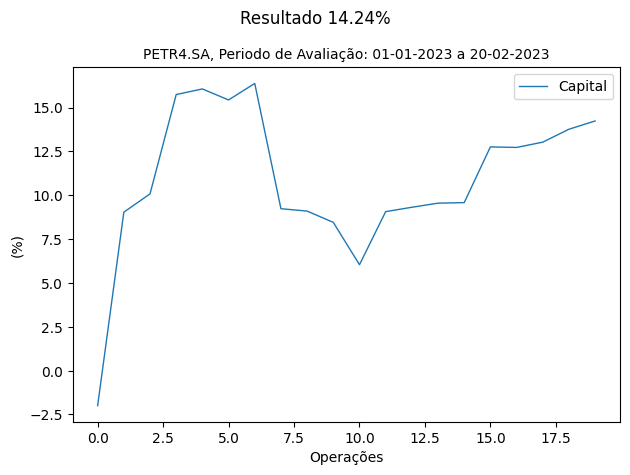

In [ ]:
def get_buy_and_hold(data):
  first_price = data.iloc[0]
  last_price = data.iloc[-1]
  return ((last_price-first_price)/first_price)*100

def get_drawdown(data):
  data['HighValue'] = data['total_profit'].cummax()
  data['Drawdown'] = data['total_profit']-data['HighValue']
  return data['Drawdown'].min(),data['Drawdown'].mean()

def run_trained_model(model_path, data, window_size):
    trader = AI_Trader(window_size)
    trader.model = tf.keras.models.load_model(model_path)

    state = state_creator(data, 0, window_size + 1)
    quant_operacoes=0
    operacoes_lucro=0
    operacoes_prejuizo=0
    total_profit = 0
    ganho=0
    perda=0
    trader.inventory.clear()
    trader.inventory = []
    gt = {'total_profit': []}

    for t in tqdm(range(len(data) - 1)):
        action = trader.trade(state, use_random_action=False)
        next_state = state_creator(data, t + 1, window_size + 1)

        # Sem ação
        if action == 0:
          # Apenas um print e Recompensa = 0
          print(" - Sem ação | Total de papeis no portfolio = ", len(trader.inventory))

        # Compra
        if action == 1:
          # Recompensa = 0

          # Adicionamos a ação comprada na array de portfolio
          trader.inventory.append(data[t])

          print(" - AI Trader Comprou: ", stock_price_format(data[t]))

        # Venda (Deve possuir ações no portfolio)
        elif action == 2 and len(trader.inventory) > 0:

          quant_operacoes+=1

          # Remove última ação do portfólio e a retorna
          buy_price = trader.inventory.pop(0)

          #total_profit += data[t] - buy_price # Soma ao lucro/prejuízo total

          if (data[t] - buy_price > 0):
            operacoes_lucro+=1
            ganho+=((data[t]-buy_price)/buy_price)*100
            total_profit +=((data[t]-buy_price)/buy_price)*100
          else:
            operacoes_prejuizo+=1
            perda+=((data[t]-buy_price)/buy_price)*100
            total_profit +=((data[t]-buy_price)/buy_price)*100

          gt['total_profit'].append(total_profit)

          print(" - AI Trader Vendeu: ", stock_price_format(data[t]), " - Lucro: " + stock_price_format(data[t] - buy_price) )
        state = next_state


    taxa_acerto=(operacoes_lucro/quant_operacoes)*100
    taxa_erro=(operacoes_prejuizo/quant_operacoes)*100

    plt.figure()
    plt.plot(gt['total_profit'],linewidth=1)
    plt.xlabel('Operações')
    plt.ylabel('(%)')
    plt.suptitle(f"Resultado {total_profit:.2f}%")
    plt.title("PETR4.SA, Periodo de Avaliação: 01-01-2023 a 20-02-2023", fontsize=10)
    plt.legend(['Capital'])
    plt.tight_layout()
    plot_filename = 'resultado_plot.png'
    plt.savefig(plot_filename)
    #files.download(plot_filename)
    aux = pd.DataFrame(gt)
    minD,meanD = get_drawdown(aux)
    print("Min = ",minD)
    print("Mean = ",meanD)

    return total_profit, taxa_acerto, taxa_erro, ganho, perda, quant_operacoes


uploaded = files.upload()
file_name = list(uploaded.keys())[0]
model_path = file_name

new_data = dataset_loader("PETR4.SA", "2021-01-01", "2023-02-20")
inicio = time.time()

total_profit, taxa_acerto, taxa_erro, ganho, perda, quant_operacoes= run_trained_model(model_path, new_data, window_size)

fim = time.time()

tempo_execucao=fim - inicio
buy_and_hold = get_buy_and_hold(new_data)
#Print do tempo que demorou para rodar a parte específica do código
print(f"Tempo de Execucao: {tempo_execucao} segundos")
print(f"Taxa de Acerto: {taxa_acerto} %")
print(f"Taxa de Erro: {taxa_erro} %")
print(f"Ganho: {ganho} %")
print(f"Perda: {abs(perda)} %")
print(f"payoff: {ganho/abs(perda)}")
print(f"Lucro Total: {total_profit}")
print(f"Buy and Hold: {buy_and_hold} %")
print(f"Total de Operacoes: {quant_operacoes}")
#vale3 petr4 itub4 bbdc4 bbas3 ,   fonte:trading map